In [ ]:
import numpy as np
import pandas as pd

import datetime, time
from sklearn import preprocessing

# Importing libraries to create visualizations:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import folium
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
# import itertools
import warnings
warnings.filterwarnings('ignore')

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
data = pd.read_csv("/content/drive/MyDrive/data602/DOHMH_New_York_City_Restaurant_Inspection_Results.csv")

###1.Inspection Data

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200060 entries, 0 to 200059
Data columns (total 27 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   CAMIS                  200060 non-null  int64  
 1   DBA                    198299 non-null  object 
 2   BORO                   200060 non-null  object 
 3   BUILDING               199673 non-null  object 
 4   STREET                 200034 non-null  object 
 5   ZIPCODE                197314 non-null  float64
 6   PHONE                  200049 non-null  object 
 7   CUISINE DESCRIPTION    195735 non-null  object 
 8   INSPECTION DATE        200060 non-null  object 
 9   ACTION                 195735 non-null  object 
 10  VIOLATION CODE         194620 non-null  object 
 11  VIOLATION DESCRIPTION  194620 non-null  object 
 12  CRITICAL FLAG          200060 non-null  object 
 13  SCORE                  189134 non-null  float64
 14  GRADE                  98639 non-nul

In [ ]:
data.shape

(200060, 27)

In [ ]:
data.columns

Index(['CAMIS', 'DBA', 'BORO', 'BUILDING', 'STREET', 'ZIPCODE', 'PHONE',
       'CUISINE DESCRIPTION', 'INSPECTION DATE', 'ACTION', 'VIOLATION CODE',
       'VIOLATION DESCRIPTION', 'CRITICAL FLAG', 'SCORE', 'GRADE',
       'GRADE DATE', 'RECORD DATE', 'INSPECTION TYPE', 'Latitude', 'Longitude',
       'Community Board', 'Council District', 'Census Tract', 'BIN', 'BBL',
       'NTA', 'Location Point1'],
      dtype='object')

##2.Remove Duplicative Data

In [ ]:
# Change the inspection date column to datetime format:
data['INSPECTION DATE'] = pd.to_datetime(data['INSPECTION DATE'])

In [ ]:
# Add a column that counts how many data entries have the same id (CAMIS) (and therefore represent the same restaurant):
data['no_of_inspections'] = data.groupby('CAMIS')['CAMIS'].transform('count')

In [ ]:
# Sort values by name (DBA), id (CAMIS), and inspection date:
data_sorted = data.sort_values(by=['DBA', 'CAMIS','INSPECTION DATE'])

In [ ]:
# Drop duplicate values:
data_filtered = data_sorted.drop_duplicates(subset=['DBA', 'CAMIS'], keep='last', inplace=False).copy()

In [ ]:
# Double check no duplicates remain:
data_filtered['count_check'] = data_filtered.groupby('CAMIS')['CAMIS'].transform('count')
print('# of Restaurants in NYC: ', len(data_filtered))
print('# of duplicates: ', len(data_filtered[data_filtered['count_check'] > 1]))
data_filtered.reset_index(inplace=True, drop = True)
data_filtered.head()

# of Restaurants in NYC:  28347
# of duplicates:  0


,CAMIS,DBA,BORO,BUILDING,STREET,ZIPCODE,PHONE,CUISINE DESCRIPTION,INSPECTION DATE,ACTION,...,Longitude,Community Board,Council District,Census Tract,BIN,BBL,NTA,Location Point1,no_of_inspections,count_check
0,50126747,"""U"" LIKE CHINESE TAKE OUT",Manhattan,4926,BROADWAY,10034.0,2129426668,Chinese,2023-02-03,Violations were cited in the following area(s).,...,-73.921726,112.0,10.0,29300.0,1082052.0,1.022350e+09,MN01,NaN,5,1
1,50075009,#1 GARDEN CHINESE RESTAURANT,Brooklyn,221,PROSPECT PARK WEST,11215.0,9172508950,Chinese,2023-02-13,Establishment re-opened by DOHMH.,...,-73.980555,307.0,39.0,16900.0,3026939.0,3.011100e+09,BK40,NaN,14,1
2,41336841,#1 SABOR LATINO RESTAURANT,Bronx,4120,WHITE PLAINS ROAD,10466.0,7186532222,Latin American,2022-11-23,Violations were cited in the following area(s).,...,-73.858591,212.0,12.0,42200.0,2063603.0,2.048430e+09,BX44,NaN,11,1
3,50086385,$1 PIZZA,Manhattan,832,6 AVENUE,10001.0,9175878888,Pizza,2023-05-02,Violations were cited in the following area(s).,...,-73.990158,105.0,3.0,7600.0,1015746.0,1.008300e+09,MN17,NaN,13,1
4,50117047,$1 PIZZA,Manhattan,333B,AVENUE OF THE AMERICAS,10014.0,9173883956,Pizza,2022-06-06,Violations were cited in the following area(s).,...,-74.001176,102.0,3.0,6700.0,1010086.0,1.005898e+09,MN23,NaN,6,1


##3.Remove Unnecessary Columns

In [ ]:
# Remove columns that we will not be working with:
data_filtered.drop(columns = ['VIOLATION CODE', 'VIOLATION DESCRIPTION', 'RECORD DATE',
                                   'Community Board', 'Council District', 'Census Tract','BIN','BBL','NTA',
                                   'count_check','Location Point1'], inplace = True, axis=1)

In [ ]:
data_filtered.shape

(28347, 18)

##4.Feature Engineering

In [ ]:
# Update format of telephone numbers:
data_filtered['PHONE']=data_filtered['PHONE'].astype(str).apply(
    lambda x: '('+x[:3]+')'+' '+x[3:6]+'-'+x[6:10])

# Rename telephone number column to match the name in the df_filtered dataset:
data_filtered.rename(columns={'PHONE':'display_phone'}, inplace=True)

In [ ]:
data_filtered.shape

(28347, 18)

##5.Dealing With Missing Data

In [ ]:
data_filtered.isnull().sum()

CAMIS                     0
DBA                    1761
BORO                      0
BUILDING                112
STREET                   26
ZIPCODE                 458
display_phone             0
CUISINE DESCRIPTION    4325
INSPECTION DATE           0
ACTION                 4325
CRITICAL FLAG             0
SCORE                  5004
GRADE                  7766
GRADE DATE             9399
INSPECTION TYPE        4325
Latitude                117
Longitude               117
no_of_inspections         0
dtype: int64

It looks like we have a few columns with null values. As per indications from the dataset creators, we will replace null values in the Action column with 'Not Yet Inspected', null values in the Critical Flag column with 'Not Applicable', and null values in the Inspection Type column with 'Unknown'.

In [ ]:
# Replace null values in ACTION column with 'Not Yet Inspected' as per guidence from dataset creators
data_filtered['ACTION'].fillna(value='Not Yet Inspected', inplace=True)

# Replace null values in CRITICAL FLAG column with 'Not Applicable' as per guidence from dataset creators
data_filtered['CRITICAL FLAG'].fillna(value='Not Applicable', inplace=True)

# Replace null values in INSPECTION TYPE column with 'Unknown' as per guidence from dataset creators
data_filtered['INSPECTION TYPE'].fillna(value='Unknown', inplace=True)

In [ ]:
data_filtered['GRADE'].value_counts()

A    16335
N     1636
B     1160
Z     1145
C      304
P        1
Name: GRADE, dtype: int64

For the null values in the Grade column, we will replace these with grade data that corresponds to the information included in the Action column as the Action typically indicates the reason for not having a grade (i.e. no grade because not yet inspected).

In [ ]:
data_filtered['GRADE'].fillna(data_filtered['ACTION'], inplace=True)

In [ ]:
data_filtered['GRADE'].value_counts()

A                                                                                                                                     16335
Not Yet Inspected                                                                                                                      4325
Violations were cited in the following area(s).                                                                                        3246
N                                                                                                                                      1636
B                                                                                                                                      1160
Z                                                                                                                                      1145
C                                                                                                                                       304
No violations were r

In [ ]:
# Use details from Action column to determine grade status for rows with null values:

data_filtered['GRADE'].replace({'Violations were cited in the following area(s).':'Z',
                                     'No violations were recorded at the time of this inspection.': 'A',
                                     'Not Yet Inspected':'N',
                                     'Establishment Closed by DOHMH. Violations were cited in the following area(s) and those requiring immediate action were addressed.':'P',
                                     'Establishment re-opened by DOHMH.': 'P'}, inplace = True)

# Ensure GRADE column has only the grade letter scores and not any text from the Action column:
data_filtered['GRADE'].value_counts()

A    16450
N     5961
Z     4391
B     1160
C      304
P       81
Name: GRADE, dtype: int64

In [ ]:
# Use details from GRADE column to determine the SCORE for rows with null values:
data_filtered['SCORE'].fillna(data_filtered['GRADE'], inplace=True)
data_filtered['SCORE'].replace({'N':'PEND',
                                     'Z': 'PEND',
                                     'P':'PEND',
                                     'A': 8,
                                     'B': 21,
                                     'C': 35}, inplace = True)

In [ ]:
data_filtered.head()

,CAMIS,DBA,BORO,BUILDING,STREET,ZIPCODE,display_phone,CUISINE DESCRIPTION,INSPECTION DATE,ACTION,CRITICAL FLAG,SCORE,GRADE,GRADE DATE,INSPECTION TYPE,Latitude,Longitude,no_of_inspections
0,50126747,"""U"" LIKE CHINESE TAKE OUT",Manhattan,4926,BROADWAY,10034.0,(212) 942-6668,Chinese,2023-02-03,Violations were cited in the following area(s).,Critical,31.0,N,NaN,Pre-permit (Operational) / Initial Inspection,40.867494,-73.921726,5
1,50075009,#1 GARDEN CHINESE RESTAURANT,Brooklyn,221,PROSPECT PARK WEST,11215.0,(917) 250-8950,Chinese,2023-02-13,Establishment re-opened by DOHMH.,Not Critical,2.0,Z,02/13/2023,Cycle Inspection / Reopening Inspection,40.660156,-73.980555,14
2,41336841,#1 SABOR LATINO RESTAURANT,Bronx,4120,WHITE PLAINS ROAD,10466.0,(718) 653-2222,Latin American,2022-11-23,Violations were cited in the following area(s).,Not Critical,11.0,A,11/23/2022,Cycle Inspection / Re-inspection,40.891176,-73.858591,11
3,50086385,$1 PIZZA,Manhattan,832,6 AVENUE,10001.0,(917) 587-8888,Pizza,2023-05-02,Violations were cited in the following area(s).,Not Critical,PEND,Z,NaN,Administrative Miscellaneous / Initial Inspection,40.746510,-73.990158,13
4,50117047,$1 PIZZA,Manhattan,333B,AVENUE OF THE AMERICAS,10014.0,(917) 388-3956,Pizza,2022-06-06,Violations were cited in the following area(s).,Critical,0.0,A,06/06/2022,Pre-permit (Operational) / Re-inspection,40.731409,-74.001176,6


In [ ]:
# Replace null values in grade date column with 'TBD' as the restaurants with no grade date do not yet have a grade.
data_filtered['GRADE DATE'].fillna(value='TBD', inplace=True)



In [ ]:
# Drop all other rows with NaN values:
data_filtered.dropna(inplace=True)

# Double check we do not have any more null values:
data_filtered.isnull().sum()


CAMIS                  0
DBA                    0
BORO                   0
BUILDING               0
STREET                 0
ZIPCODE                0
display_phone          0
CUISINE DESCRIPTION    0
INSPECTION DATE        0
ACTION                 0
CRITICAL FLAG          0
SCORE                  0
GRADE                  0
GRADE DATE             0
INSPECTION TYPE        0
Latitude               0
Longitude              0
no_of_inspections      0
dtype: int64

##6.Dealing With Outliers

In [ ]:
# Check For Outliers:
data_filtered.describe()

,CAMIS,ZIPCODE,Latitude,Longitude,no_of_inspections
count,2.355800e+04,23558.000000,23558.000000,23558.000000,23558.000000
mean,4.742850e+07,10688.204474,40.727510,-73.943319,8.176416
std,4.077393e+06,593.562771,0.068819,0.076652,5.731571
min,3.007544e+07,10000.000000,40.499563,-74.248708,1.000000
25%,4.162924e+07,10022.000000,40.686880,-73.989165,4.000000
50%,5.005955e+07,10471.000000,40.732966,-73.958958,7.000000
75%,5.010253e+07,11229.000000,40.762000,-73.902649,11.000000
max,5.013569e+07,12345.000000,40.912822,-73.700928,65.000000


The no_of_inspections column seems to have some outliers. Rather than completely removing these outliers since they likely primarily represent restaurants with a 'C' grade who have been inspected many times as a result of having many violations and we don't want to remove just one specific group of restaurants, we will replace the outlier values in this column so they no longer are significant outliers. For the number of inspections column, anything with more than 70 inspections will be updated to say it has 70 inspections, which still indicates that the restaurant had a large number of inspections.

In [ ]:
# Convert outliers in number of inspections column to have a value of '70'
data_filtered['no_of_inspections'] = np.where(data_filtered['no_of_inspections'].between(
    70,98), 70, data_filtered['no_of_inspections'])

In [ ]:
# Create a temporary dataframe that includes only the restaurants that have been given an inspection grade:
df_inspec_filtered_temp = data_filtered.loc[data_filtered['GRADE'].isin(['A','B','C'])].copy()


temp = df_inspec_filtered_temp['GRADE'].groupby(df_inspec_filtered_temp['BORO']).count().sort_values(ascending=False)
# List in descending order the number of inspected restaurants in each borough:
print('no Of Restaurants Per Borough:','\n',
      temp)

no Of Restaurants Per Borough: 
 BORO
Manhattan        6784
Brooklyn         4611
Queens           3956
Bronx            1487
Staten Island     698
Name: GRADE, dtype: int64


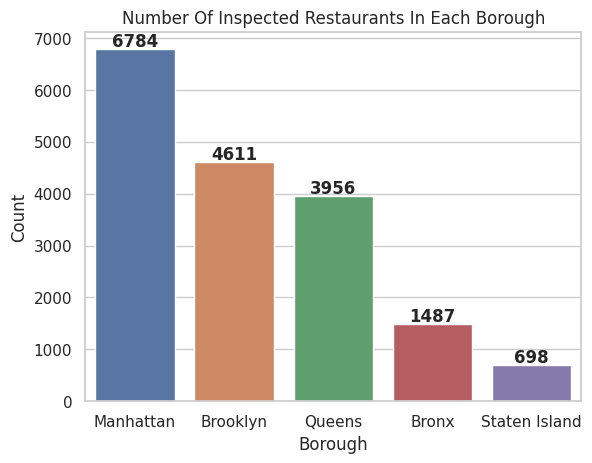

In [ ]:
sns.set(style="whitegrid")

# Create the bar plot
sns.barplot(x=temp.index, y=temp.values)

# Add labels and title to the graph
plt.xlabel('Borough')
plt.ylabel('Count')
plt.title('Number Of Inspected Restaurants In Each Borough')

# Add data labels
for i, v in enumerate(temp.values):
    plt.text(i, v+50, str(v), ha='center', fontweight='bold')

# Show the plot
plt.show()

## 7. EDA and Visualization

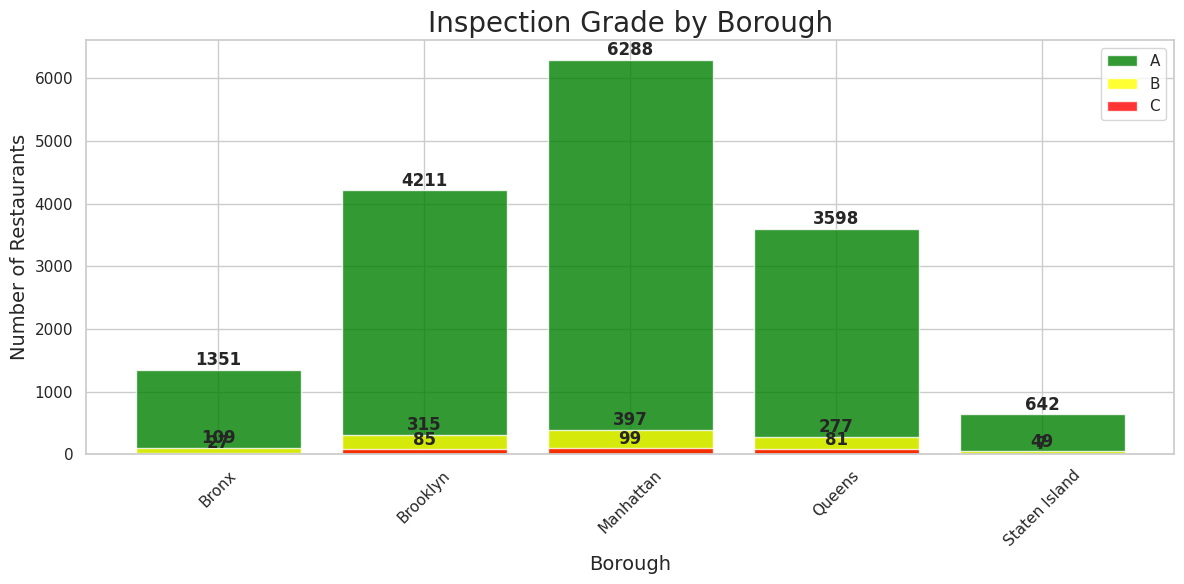

In [ ]:

# Create a figure and set its size
plt.figure(figsize=(12, 6))

# Group and count the inspections by borough and grade
grouped = df_inspec_filtered_temp.groupby(['BORO', 'GRADE']).size().unstack()

# Get the boroughs and grades from the grouped DataFrame
boroughs = grouped.index
grades = grouped.columns

# Set the color scheme for the grades
colors = ['green', 'yellow', 'red']

# Iterate over the grades and create a bar for each borough
for i, grade in enumerate(grades):
    plt.bar(boroughs, grouped[grade], label=grade, color=colors[i], alpha=0.8)

# Add value labels on top of each bar
for borough in boroughs:
    for i, grade in enumerate(grades):
        count = grouped.loc[borough, grade]
        plt.text(borough, count + 10, str(count), ha='center', va='bottom', fontweight='bold')

# Add chart title and labels
plt.title('Inspection Grade by Borough', fontsize=20)
plt.xlabel('Borough', fontsize=14)
plt.ylabel('Number of Restaurants', fontsize=14)

# Rotate the x-axis labels for better readability
plt.xticks(rotation=45)

# Add a legend
plt.legend()

# Show the plot
plt.tight_layout()
plt.show()

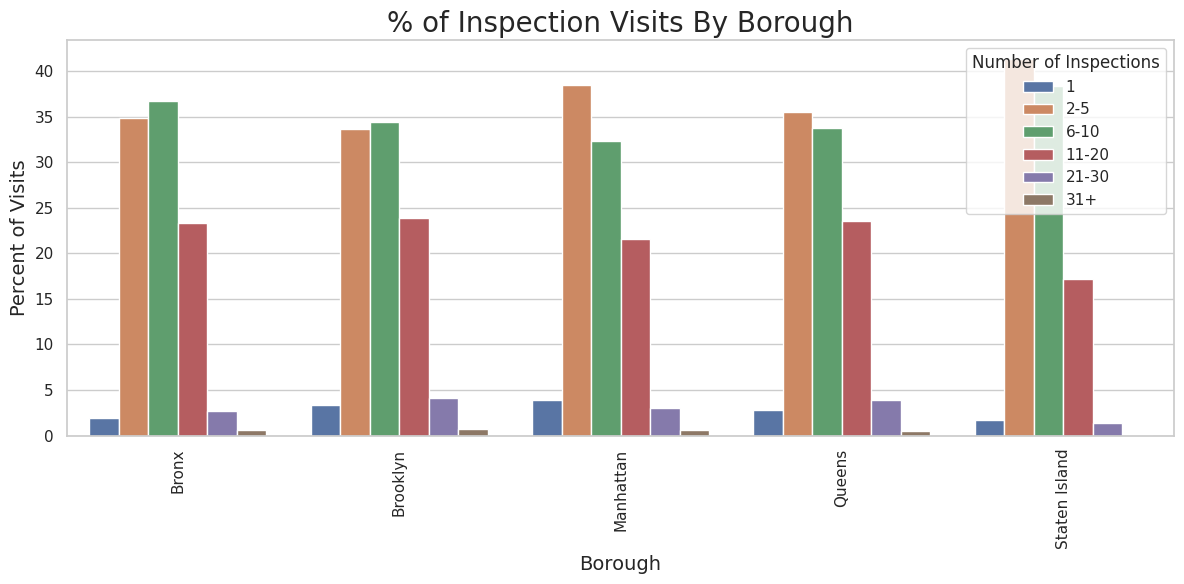

In [ ]:
# Define a function to assign range labels
def count_range(x):
    if x == 1:
        return '1'
    elif 2 <= x <= 5:
        return '2-5'
    elif 6 <= x <= 10:
        return '6-10'
    elif 11 <= x <= 20:
        return '11-20'
    elif 21 <= x <= 30:
        return '21-30'
    else:
        return '31+'

# Add a new column for count ranges
data_filtered['count_range'] = data_filtered['no_of_inspections'].apply(count_range)

# Calculate the percentage of visits for each borough and count range
percentage_data = data_filtered.groupby('BORO')['count_range'].value_counts(normalize=True).mul(100).rename('Percent of Visits').reset_index()

# Create the bar plot
plt.figure(figsize=(12, 6))
sns.barplot(data=percentage_data, x='BORO', y='Percent of Visits', hue='count_range',
            hue_order=['1', '2-5', '6-10', '11-20', '21-30', '31+'])

# Add chart title, labels, and legend
plt.title('% of Inspection Visits By Borough', fontsize=20)
plt.xlabel('Borough', fontsize=14)
plt.ylabel('Percent of Visits', fontsize=14)
plt.legend(title='Number of Inspections')

# Rotate the x-axis labels for better readability
plt.xticks(rotation='vertical')

# Show the plot
plt.tight_layout()
plt.show()

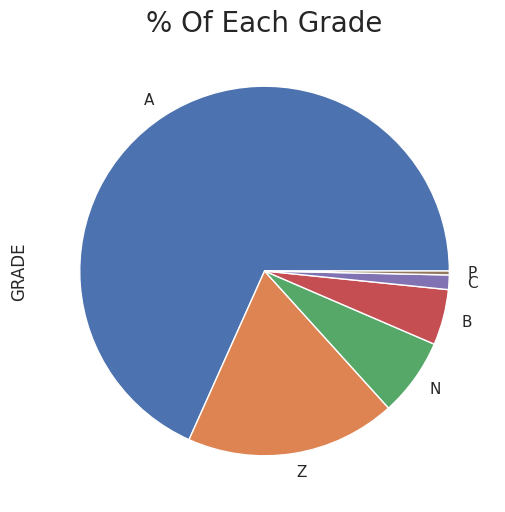

In [ ]:
# Plot a pie chart that shows the breakout of each grade:
plt.figure(figsize=(12,6))
data_filtered['GRADE'].value_counts().plot(kind='pie')
plt.title('% Of Each Grade', fontsize=20);

In [ ]:
data_filtered.columns

Index(['CAMIS', 'DBA', 'BORO', 'BUILDING', 'STREET', 'ZIPCODE',
       'display_phone', 'CUISINE DESCRIPTION', 'INSPECTION DATE', 'ACTION',
       'CRITICAL FLAG', 'SCORE', 'GRADE', 'GRADE DATE', 'INSPECTION TYPE',
       'Latitude', 'Longitude', 'no_of_inspections', 'count_range'],
      dtype='object')

In [ ]:
data_filtered['SCORE'].value_counts()

12.0     3344
13.0     2661
10.0     2185
7.0      1506
9.0      1487
         ... 
110.0       1
95.0        1
98.0        1
92.0        1
109.0       1
Name: SCORE, Length: 102, dtype: int64

In [ ]:
data_filtered.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23558 entries, 0 to 26583
Data columns (total 19 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   CAMIS                23558 non-null  int64         
 1   DBA                  23558 non-null  object        
 2   BORO                 23558 non-null  object        
 3   BUILDING             23558 non-null  object        
 4   STREET               23558 non-null  object        
 5   ZIPCODE              23558 non-null  float64       
 6   display_phone        23558 non-null  object        
 7   CUISINE DESCRIPTION  23558 non-null  object        
 8   INSPECTION DATE      23558 non-null  datetime64[ns]
 9   ACTION               23558 non-null  object        
 10  CRITICAL FLAG        23558 non-null  object        
 11  SCORE                23558 non-null  object        
 12  GRADE                23558 non-null  object        
 13  GRADE DATE           23558 non-

In [ ]:
data_filtered.shape

(23558, 19)

In [ ]:
data_filtered['DBA']

0               "U" LIKE CHINESE TAKE OUT
1            #1 GARDEN CHINESE RESTAURANT
2              #1 SABOR LATINO RESTAURANT
3                                $1 PIZZA
4                                $1 PIZZA
                       ...               
26564                       cafe paulette
26572    kampai hibachi & brazilian Grill
26573                   kokomo restaurant
26577                       matchpointnyc
26583                     tutto il giorno
Name: DBA, Length: 23558, dtype: object

In [ ]:
data_filtered['BORO'].value_counts()

Manhattan        8948
Brooklyn         6137
Queens           5413
Bronx            2164
Staten Island     896
Name: BORO, dtype: int64

In [ ]:
data_filtered['CUISINE DESCRIPTION'].value_counts()

American        4505
Chinese         2037
Coffee/Tea      1690
Pizza           1460
Italian          928
                ... 
Southwestern       2
Chilean            2
Iranian            2
Armenian           2
Basque             1
Name: CUISINE DESCRIPTION, Length: 87, dtype: int64

In [ ]:
data_filtered['ACTION'].value_counts()

Violations were cited in the following area(s).                                                                                       22774
Establishment re-opened by DOHMH.                                                                                                       459
No violations were recorded at the time of this inspection.                                                                             263
Establishment Closed by DOHMH. Violations were cited in the following area(s) and those requiring immediate action were addressed.       62
Name: ACTION, dtype: int64

In [ ]:
data_filtered['CRITICAL FLAG'].value_counts()

Critical          11945
Not Critical      11236
Not Applicable      377
Name: CRITICAL FLAG, dtype: int64

In [ ]:
data_filtered['INSPECTION TYPE'].value_counts()

Cycle Inspection / Initial Inspection                          12888
Cycle Inspection / Re-inspection                                5885
Pre-permit (Operational) / Initial Inspection                   2091
Pre-permit (Operational) / Re-inspection                         941
Administrative Miscellaneous / Initial Inspection                446
Cycle Inspection / Reopening Inspection                          396
Pre-permit (Non-operational) / Initial Inspection                295
Pre-permit (Operational) / Compliance Inspection                 142
Administrative Miscellaneous / Re-inspection                      97
Cycle Inspection / Compliance Inspection                          87
Pre-permit (Operational) / Reopening Inspection                   58
Smoke-Free Air Act / Initial Inspection                           49
Pre-permit (Non-operational) / Re-inspection                      42
Inter-Agency Task Force / Initial Inspection                      34
Calorie Posting / Initial Inspecti

In [ ]:
data_filtered['SCORE'].count()

23558

In [ ]:
data_filtered[data_filtered['SCORE']=='PEND'].count()

CAMIS                  583
DBA                    583
BORO                   583
BUILDING               583
STREET                 583
ZIPCODE                583
display_phone          583
CUISINE DESCRIPTION    583
INSPECTION DATE        583
ACTION                 583
CRITICAL FLAG          583
SCORE                  583
GRADE                  583
GRADE DATE             583
INSPECTION TYPE        583
Latitude               583
Longitude              583
no_of_inspections      583
count_range            583
dtype: int64

In [ ]:
data_filtered['ZIPCODE'].value_counts

<bound method IndexOpsMixin.value_counts of 0        10034.0
1        11215.0
2        10466.0
3        10001.0
4        10014.0
          ...   
26564    11217.0
26572    11366.0
26573    11249.0
26577    11223.0
26583    10013.0
Name: ZIPCODE, Length: 23558, dtype: float64>

In [ ]:
df = data_filtered
df = df.replace('PEND', 0)
df['SCORE'] = df['SCORE'].astype(float)

# Handle missing and non-numeric values
df['SCORE'] = pd.to_numeric(df['SCORE'], errors='coerce')
df['SCORE'].fillna(0, inplace=True)


In [ ]:
score_range = df['SCORE'].max() - df['SCORE'].min()

# Print the range
print("The range of the 'score' column is:", score_range)

The range of the 'score' column is: 140.0


In [ ]:
data_filtered['no_of_inspections']

0         5
1        14
2        11
3        13
4         6
         ..
26564    13
26572     8
26573     7
26577    13
26583    11
Name: no_of_inspections, Length: 23558, dtype: int64

In [ ]:
data_filtered.head(1)

,CAMIS,DBA,BORO,BUILDING,STREET,ZIPCODE,display_phone,CUISINE DESCRIPTION,INSPECTION DATE,ACTION,CRITICAL FLAG,SCORE,GRADE,GRADE DATE,INSPECTION TYPE,Latitude,Longitude,no_of_inspections,count_range
0,50126747,"""U"" LIKE CHINESE TAKE OUT",Manhattan,4926,BROADWAY,10034.0,(212) 942-6668,Chinese,2023-02-03,Violations were cited in the following area(s).,Critical,31.0,N,TBD,Pre-permit (Operational) / Initial Inspection,40.867494,-73.921726,5,2-5


##Converting categorical data to numerical data

In [ ]:
boro_data = pd.get_dummies(data_filtered['BORO'])
boro_data = boro_data.add_prefix('BORO_')

In [ ]:
boro_data.head()

,BORO_Bronx,BORO_Brooklyn,BORO_Manhattan,BORO_Queens,BORO_Staten Island
0,0,0,1,0,0
1,0,1,0,0,0
2,1,0,0,0,0
3,0,0,1,0,0
4,0,0,1,0,0


In [ ]:
data_filtered = pd.concat([data_filtered, boro_data], axis=1)

###Analysis of "ACTION" Column <br>
**Violations** -  Violations were cited in the following area(s). <br>
**Establishment  re-opened** - Establishment re-opened by DOHMH.<br>
**No violations** -  No violations were recorded at the time of this inspection.<br>
Establishment Closed -  Establishment Closed by DOHMH. Violations were cited in the following area(s) and those requiring immediate action were addressed.<br>

In [ ]:
data_filtered['ACTION'].replace({'Violations were cited in the following area(s).':'Violations',
                                     'No violations were recorded at the time of this inspection.': 'No violations',
                                     'Establishment Closed by DOHMH. Violations were cited in the following area(s) and those requiring immediate action were addressed.':'Establishment Closed',
                                     'Establishment re-opened by DOHMH.': 'Establishment re-opened'}, inplace = True)
data_filtered['ACTION'].value_counts()


Violations                 22774
Establishment re-opened      459
No violations                263
Establishment Closed          62
Name: ACTION, dtype: int64

In [ ]:
Action_data = pd.get_dummies(data_filtered['ACTION'])
Action_data = Action_data.add_prefix('ACTION_')

In [ ]:
data_filtered = pd.concat([data_filtered, Action_data], axis=1)

In [ ]:
data_filtered.head(2)

,CAMIS,DBA,BORO,BUILDING,STREET,ZIPCODE,display_phone,CUISINE DESCRIPTION,INSPECTION DATE,ACTION,...,count_range,BORO_Bronx,BORO_Brooklyn,BORO_Manhattan,BORO_Queens,BORO_Staten Island,ACTION_Establishment Closed,ACTION_Establishment re-opened,ACTION_No violations,ACTION_Violations
0,50126747,"""U"" LIKE CHINESE TAKE OUT",Manhattan,4926,BROADWAY,10034.0,(212) 942-6668,Chinese,2023-02-03,Violations,...,2-5,0,0,1,0,0,0,0,0,1
1,50075009,#1 GARDEN CHINESE RESTAURANT,Brooklyn,221,PROSPECT PARK WEST,11215.0,(917) 250-8950,Chinese,2023-02-13,Establishment re-opened,...,11-20,0,1,0,0,0,0,1,0,0


In [ ]:
Critical_flag_data = pd.get_dummies(data_filtered['CRITICAL FLAG'])
Critical_flag_data = Critical_flag_data.add_prefix('CRITICAL_FLAG_')
data_filtered = pd.concat([data_filtered, Critical_flag_data], axis=1)

In [ ]:
Grade_data = pd.get_dummies(data_filtered['GRADE'])
Grade_data = Grade_data.add_prefix('GRADE_')
data_filtered = pd.concat([data_filtered, Grade_data], axis=1)

In [ ]:
inspection_data = pd.get_dummies(data_filtered['INSPECTION TYPE'])
inspection_data = inspection_data.add_prefix('INSPECTION_')
data_filtered = pd.concat([data_filtered, inspection_data], axis=1)

In [ ]:
data_filtered.shape

(23558, 64)

In [ ]:
data_filtered['SCORE'] = pd.to_numeric(data_filtered['SCORE'], errors='coerce')
data_filtered['SCORE'].fillna(0, inplace=True)

In [ ]:
X = data_filtered.drop(['BORO', 'ACTION', 'CRITICAL FLAG', 'GRADE', 'INSPECTION TYPE','DBA','CAMIS','BUILDING','STREET','ZIPCODE','display_phone','CUISINE DESCRIPTION','INSPECTION DATE','Latitude','Longitude','GRADE DATE','count_range', 'SCORE'], axis=1 )
y = data_filtered[['SCORE']]

## 8. Regression

For the purpose of training the models, we have selected the following features: 'BORO', 'ACTION', 'CRITICAL FLAG', 'GRADE', 'INSPECTION TYPE', 'no_of_inspections'.
We are trying to predict the 'SCORE'.

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.3, random_state=12)

In [ ]:
print(X_train.shape, X_test.shape)

(16490, 46) (7068, 46)


In [ ]:
print(Y_train.shape, Y_test.shape)

(16490, 1) (7068, 1)


In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

In [ ]:
model_lin=LinearRegression()
model_log = LogisticRegression()
model_gb = GradientBoostingRegressor()
model_rf = RandomForestRegressor()

In [ ]:
#Fitting each regression model
model_lin.fit(X_train, Y_train)
model_log.fit(X_train, Y_train)
model_gb.fit(X_train, Y_train)
model_rf.fit(X_train, Y_train)

RandomForestRegressor()

In [ ]:
#Make predictions on the test set using each model
y_pred_lin = model_lin.predict(X_test)
y_pred_log = model_log.predict(X_test)
y_pred_gb = model_gb.predict(X_test)
y_pred_rf = model_rf.predict(X_test)


In [ ]:
#Evaluating the performance of each model
mse_lin = mean_squared_error(Y_test, y_pred_lin)
r2_lin = r2_score(Y_test, y_pred_lin)

mse_log = mean_squared_error(Y_test, y_pred_log)
r2_log = r2_score(Y_test, y_pred_log)

mse_gb = mean_squared_error(Y_test, y_pred_gb)
r2_gb = r2_score(Y_test, y_pred_gb)

mse_rf = mean_squared_error(Y_test, y_pred_rf)
r2_rf = r2_score(Y_test, y_pred_rf)

print("Linear Regression:")
print("Mean Squared Error:", mse_lin)
print("R-squared Score:", r2_lin)
print()

print("Logistic Regression:")
print("Mean Squared Error:", mse_log)
print("R-squared Score:", r2_log)
print()

print("Gradient Boosting Regression:")
print("Mean Squared Error:", mse_gb)
print("R-squared Score:", r2_gb)
print()

print("Random Forest Regression:")
print("Mean Squared Error:", mse_rf)
print("R-squared Score:", r2_rf)
print()


Linear Regression:
Mean Squared Error: 39.797251040409364
R-squared Score: 0.6188912598366969

Logistic Regression:
Mean Squared Error: 74.48882286361064
R-squared Score: 0.286675820674822

Gradient Boosting Regression:
Mean Squared Error: 33.55064558635942
R-squared Score: 0.6787103647410266

Random Forest Regression:
Mean Squared Error: 36.38077118345044
R-squared Score: 0.6516083520990956



Based on the provided metrics, the best model appears to be **Gradient Boosting Regression** since it has lower MSE score and highest r2 score.


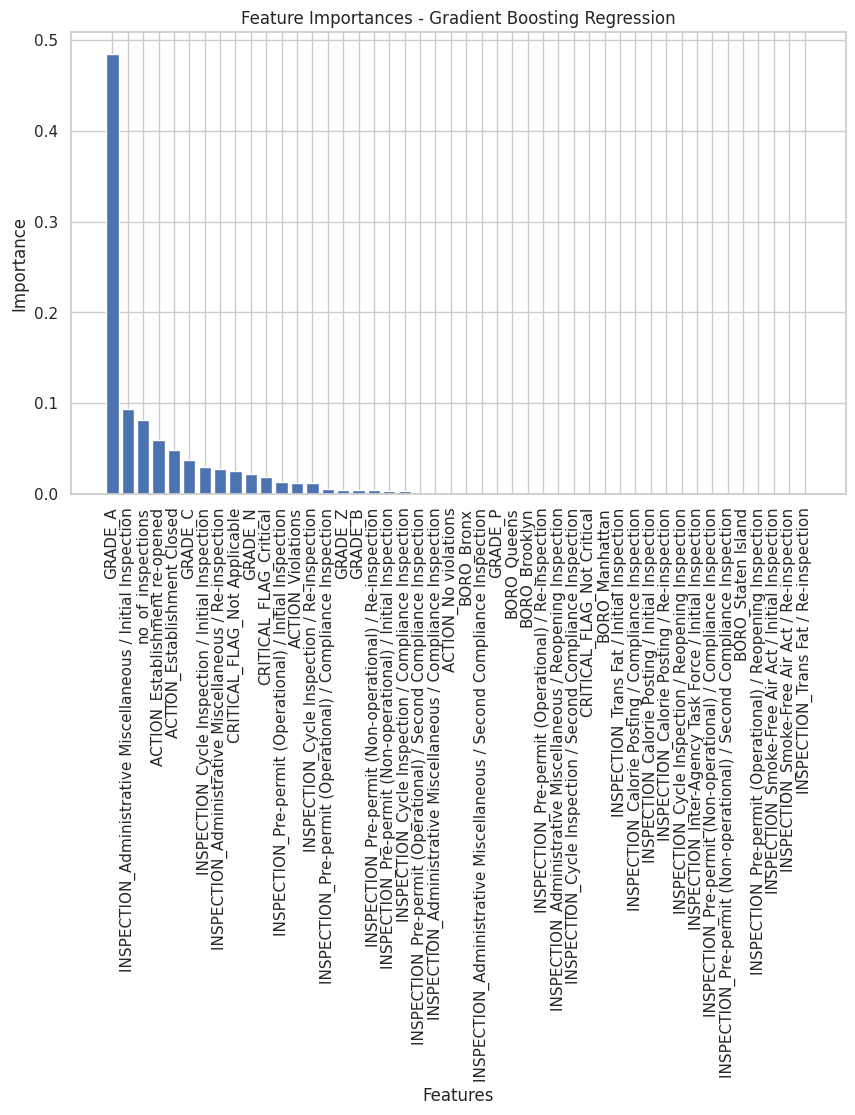

In [ ]:
importances = model_gb.feature_importances_

# Get feature names
feature_names = X.columns
# Sort feature importances in descending order
indices = np.argsort(importances)[::-1]

# Plot feature importances
plt.figure(figsize=(10, 6))
plt.title("Feature Importances - Gradient Boosting Regression")
plt.bar(range(X.shape[1]), importances[indices], align="center")
plt.xticks(range(X.shape[1]), feature_names[indices], rotation=90)
plt.xlabel("Features")
plt.ylabel("Importance")
plt.tight_layout()
plt.show()

## 9. Hyperparameter tuning

In [ ]:
from sklearn.model_selection import GridSearchCV
param_grid = {
    'n_estimators': [100, 200, 300],  # Number of estimators (trees)
    'learning_rate': [0.1, 0.01, 0.001],  # Learning rate
    'max_depth': [3, 4, 5],  # Maximum depth of trees
}

# Perform grid search with cross-validation
grid_search = GridSearchCV(estimator=model_gb, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train, Y_train)  # X_train and y_train are your training data

# Retrieve the best model and its hyperparameters
best_model = grid_search.best_estimator_
best_params = grid_search.best_params_

# Evaluate the performance of the best model on the test data
y_pred = best_model.predict(X_test)  # X_test is your test data
mse = mean_squared_error(Y_test, y_pred)
r2 = r2_score(Y_test, y_pred)

print("Best hyperparameters:", best_params)
print("Mean Squared Error:", mse)
print("R-squared Score:", r2)

Best hyperparameters: {'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 200}
Mean Squared Error: 31.791783446568243
R-squared Score: 0.6955536822238377


There is an improvement in the model performance after Hyperparameter tuning.

In [ ]:
from sklearn.model_selection import cross_val_score
model_gb = GradientBoostingRegressor(**best_params)

# Perform cross-validation with early stopping
cv_scores = []
n_iterations = 1000  # Maximum number of iterations for early stopping
for i in range(10):  # Number of cross-validation folds (can be adjusted)
    # Perform cross-validation with early stopping
    model_gb.set_params(n_estimators=n_iterations)
    scores = cross_val_score(model_gb, X_train, Y_train, cv=5, scoring='neg_mean_squared_error')
    cv_scores.append(scores.mean())

    # Check if the performance has started deteriorating (early stopping condition)
    if i > 0 and cv_scores[i] > cv_scores[i-1]:
        break

    # Decrease the number of iterations for the next fold
    n_iterations -= 100

# Determine the optimal number of iterations (early stopping point)
optimal_iterations = (len(cv_scores) - 1) * 100

# Train the model with the optimal number of iterations
model_gb.set_params(n_estimators=optimal_iterations)
model_gb.fit(X_train, Y_train)

# Evaluate the performance of the model on the test data
y_pred = model_gb.predict(X_test)
mse = mean_squared_error(Y_test, y_pred)
r2 = r2_score(Y_test, y_pred)

print("Optimal Iterations:", optimal_iterations)
print("Mean Squared Error:", mse)
print("R-squared Score:", r2)

Optimal Iterations: 100
Mean Squared Error: 32.14724978850772
R-squared Score: 0.6921496448542852
